##  This notebook performs the following tasks based on [DBLP_ACM](http://dbs.uni-leipzig.de/de/research/projects/object_matching/fever/benchmark_datasets_for_entity_resolution) dataset:

#### 1. Loads and (optionally) converts data to UTF-8 format.
#### 2. Provides an overview of the two datasets.
#### 3. Cleans and prepares data to dedupe compliance format.
#### 4. Performs record linkage.
#### 5. Evaluates record linkage results with ground truth.
#### 6. Plots statistical results from the record linkage.
#### 7. Selects the best result and generates network graph.
#### 8. Provides an overview of graph analytics.

---------
TODO:
    
    - [] comment code
    - [] check data conversion accuracy
    - [] to leverage previously trained data from active learning, write fout_training to the same file in every run.
    - [] use different color palette to plot_mean_bar()
    - [] draw interactive graph with bokeh
    - [] create library package for sna_
    
    
    
---------
KNOWN ISSUES:

- If dedupe does not response after matching record, click Notebook -> Restart Kernel and Notebook -> Run All Cells, the matching output will be ready at output folder.



---------------------------
### Configure the following parameters for experiments

In [1]:
# Configure number of run and initial run index
NUM_RUN                      = 1
UNIQUE_RUN_ID                = 10001

# Configure data conversion
CONVERT_DATA                 = False               # Check data encoding format and convert to utf-8 if True.
IS_DATASET1_CONVERTED        = False               # Dedupe will read from utf-8 input file instead of original folder if True
IS_DATASET2_CONVERTED        = False               # Dedupe will read from utf-8 input file instead of original folder if True
READ_CONVERTED_DATASET1      = True                # Dedupe will read from utf-8 input file instead of original folder if True
READ_CONVERTED_DATASET2      = True                # Dedupe will read from utf-8 input file instead of original folder if True

# Configure LSH params for name matching
SIM_THRES                    = 0.1    # 0.5
NUM_PERM                     = 128    # 128

# Configure GEPHI graph
GEN_GRAPH                    = False                # Generate GML if True, else read existing author_paper_gml

-----

In [2]:
import io
import chardet

import re
import unicodecsv as csv
from unidecode import unidecode

import os
import dedupe

import codecs
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt

from datasketch import MinHash, MinHashLSH
import networkx as nx
from sna_graph import SNA_Graph
from sna_connected_component import SNA_ConnectedComponent
from sna_analytics import SNA_Analytics

import holoviews as hv
import bokeh as bokeh

In [3]:
# Input/output directory and files
acm_csv          = "ACM.csv"
dblp_csv         = "DBLP2.csv"
fin_dir          = "data/DBLP_ACM/"
fout_dir         = "output/DBLP_ACM/"
fin_set1         = fin_dir + acm_csv
fin_set2         = fin_dir + dblp_csv
futf_set1        = fout_dir + 'utf8_' + acm_csv
futf_set2        = fout_dir + 'utf8_' + dblp_csv

# Dedupe default file name
fout_res         = fout_dir + 'data_matching_output.csv'
fout_training    = fout_dir + 'data_matching_training.json'
fout_settings    = fout_dir + 'data_matching_learned_settings'

# DBLP_ACM ground truth & matching results
fground          = fin_dir + 'DBLP-ACM_perfectMapping.csv'
fstats           = fout_dir + 'matching_stats.csv'

# Gephi network graph
fres_dedupe             = fout_dir + 'data_matching_output.csv'   # default best results
author_paper_gml        = fout_dir + 'author_paper.gml'
connected_component_gml = fout_dir + 'connected_component'

In [4]:
def getDedupeOutputFilename(run_id):
    fout_res         = fout_dir + 'data_matching_output_' + str(run_id) + '.csv'
    fout_training    = fout_dir + 'data_matching_training_' + str(run_id) + '.json'
    fout_settings    = fout_dir + 'data_matching_learned_settings_' + str(run_id)
    return [fout_res, fout_training, fout_settings]

## This section loads and converts data to UTF-8 format.

In [5]:
def loadRawData(infile):
    rawdata = io.open(infile, 'rb').read() 
    return rawdata

In [6]:
def checkIsUtf8(data):
    result = chardet.detect(data) 
    charenc = result['encoding']
    if charenc != 'utf8' and charenc != 'utf-8':
        return [False, charenc]
    else:
        return [True, charenc]

In [7]:
def convertToUtf8(data, charenc):
    print ("Converting " + charenc + " to UTF-8")
    data = data.decode(charenc).encode("utf-8")
    return data

In [8]:
def loadData(infile):
    data = loadRawData(infile)
    [is_utf8, charenc] = checkIsUtf8(data)
    if not is_utf8:
        data = convertToUtf8(data, charenc)
    return data

# data_1 = loadData(fin_set1)
# data_2 = loadData(fin_set2)

In [9]:
def convertNWriteToUtf8(data, charenc, outfile):
    data = data.decode(charenc).encode('utf-8')
    io.open(outfile, 'wb').write(data) 

In [10]:
def writeToUtf8(infile, outfile):
    data = loadRawData(infile)
    [is_utf8, charenc] = checkIsUtf8(data)
    if not is_utf8:
        print ("Converting " + infile + " with " + charenc + " to UTF-8 and store in " + outfile)
        convertNWriteToUtf8(data, charenc, outfile)
        return True
    else:
        return False

In [11]:
# Perform data conversion
if CONVERT_DATA:
    IS_DATASET1_CONVERTED = writeToUtf8(fin_set1, futf_set1)
    IS_DATASET2_CONVERTED = writeToUtf8(fin_set2, futf_set2)
    
if IS_DATASET1_CONVERTED or READ_CONVERTED_DATASET1:
    fset1 = futf_set1
else: 
    fset1 = fin_set1
    
if IS_DATASET2_CONVERTED or READ_CONVERTED_DATASET2:
    fset2 = futf_set2
else: 
    fset2 = fin_set2

## This section provides an overview of the two datasets.

In [12]:
df_acm = pd.read_csv(fset1, encoding='utf-8')
df_acm.head()

,id,title,authors,venue,year
0,304586,The WASA2 object-oriented workflow management ...,"Gottfried Vossen, Mathias Weske",International Conference on Management of Data,1999
1,304587,A user-centered interface for querying distrib...,"Isabel F. Cruz, Kimberly M. James",International Conference on Management of Data,1999
2,304589,"World Wide Database-integrating the Web, CORBA...","Athman Bouguettaya, Boualem Benatallah, Lily H...",International Conference on Management of Data,1999
3,304590,XML-based information mediation with MIX,"Chaitan Baru, Amarnath Gupta, Bertram Lud&#228...",International Conference on Management of Data,1999
4,304582,The CCUBE constraint object-oriented database ...,"Alexander Brodsky, Victor E. Segal, Jia Chen, ...",International Conference on Management of Data,1999


In [13]:
df_dblp2 = pd.read_csv(fset2, encoding='utf-8')
df_dblp2.head()

,id,title,authors,venue,year
0,journals/sigmod/Mackay99,Semantic Integration of Environmental Models f...,D. Scott Mackay,SIGMOD Record,1999
1,conf/vldb/PoosalaI96,Estimation of Query-Result Distribution and it...,"Viswanath Poosala, Yannis E. Ioannidis",VLDB,1996
2,conf/vldb/PalpanasSCP02,Incremental Maintenance for Non-Distributive A...,"Themistoklis Palpanas, Richard Sidle, Hamid Pi...",VLDB,2002
3,conf/vldb/GardarinGT96,Cost-based Selection of Path Expression Proces...,"Zhao-Hui Tang, Georges Gardarin, Jean-Robert G...",VLDB,1996
4,conf/vldb/HoelS95,Benchmarking Spatial Join Operations with Spat...,"Erik G. Hoel, Hanan Samet",VLDB,1995


## This section cleans and prepares data to dedupe compliance format.

In [14]:
def preProcess(column):
    """
    Do a little bit of data cleaning with the help of Unidecode and Regex.
    Things like casing, extra spaces, quotes and new lines can be ignored.
    """
    column = unidecode(column)
    column = re.sub('\n', ' ', column)
    column = re.sub('-', '', column)
    column = re.sub('/', ' ', column)
    column = re.sub("'", '', column)
    column = re.sub(",", '', column)
    column = re.sub(":", ' ', column)
    column = re.sub('  +', ' ', column)
    column = column.strip().strip('"').strip("'").lower().strip()
    if not column :
        column = None
    return column

In [15]:
def readData(filename):
    """
    Read in our data from a CSV file and create a dictionary of records, 
    where the key is a unique record ID.
    """

    data_d = {}
    
    with io.open(filename, 'rb') as f:
        reader = csv.DictReader(f)             
        for i, row in enumerate(reader):                 
            #print row
            clean_row = []
            for k, v in row.items():                
                if k == 'authors':
                    proc_str = v.split(',')
                    proc_str = tuple([preProcess(a) for a in proc_str])
                    clean_row.append((k, proc_str))
                else:
                    clean_row.append((k, preProcess(v)))                    
            #clean_row = dict([(k, preProcess(v)) for (k, v) in row.items()])            
            data_d[filename + str(i)] = dict(clean_row)    
    return data_d

In [16]:
print('importing data from ' + fset1 + ' ...')
data_1 = readData(fset1)
print('importing data from ' + fset2 + ' ...')
data_2 = readData(fset2)

importing data from output/DBLP_ACM/utf8_ACM.csv ...
importing data from output/DBLP_ACM/utf8_DBLP2.csv ...


## This section performs record linkage. 
### Dedupe first trains a record linkage linker, then it performs blocking and matching and writes the result to a file.
### To leverage previously trained data from active learning, write fout_training to the same file in every run.

In [17]:
def define_fields():
    # 'DBLP-ACM/ACM.csv585': {
    #     'title': 'the tvtree an index structure for highdimensional data', 
    #     'authors': ('king ip lin', 'h. v. jagadish', 'christos faloutsos'), 
    #     'venue': 'the vldb journal &mdash; the international journal on very large data bases', 
    #     'id': '615210', 
    #     'year': '1994'}
    # Define the fields the linker will pay attention to
    #
    # TODO:  use corpus for authors Set
    fields = [
            {'field' : 'title', 'type': 'String'},
            {'field' : 'venue', 'type': 'String'},
            {'field' : 'id', 'type': 'String'},
            {'field' : 'year', 'type': 'ShortString'},
            {'field' : 'authors', 'type': 'Set'}]
    return fields

In [18]:
def train(fout_training, fout_settings, data_1, data_2):
    if os.path.exists(fout_settings):
        print('reading from', fout_settings)
        with io.open(fout_settings, 'rb') as sf :
            linker = dedupe.StaticRecordLink(sf)
    else:
        # Define fields format
        fields = define_fields()

        # Create a new linker object and pass our data model to it.
        linker = dedupe.RecordLink(fields)

        # To train the linker, we feed it a sample of records.
        linker.sample(data_1, data_2, 15000)

        # If we have training data saved from a previous run of linker,
        # look for it an load it in.
        # __Note:__ if you want to train from scratch, delete the training_file
        if os.path.exists(fout_training):
            print('reading labeled examples from ', fout_training)
            with open(fout_training) as tf :
                linker.readTraining(tf)

        # ## Active learning
        # Dedupe will find the next pair of records
        # it is least certain about and ask you to label them as matches
        # or not.
        # use 'y', 'n' and 'u' keys to flag duplicates
        # press 'f' when you are finished
        print('starting active labeling...')

        dedupe.consoleLabel(linker)

        linker.train()

        # When finished, save our training away to disk
        with open(fout_training, 'w') as tf :
            linker.writeTraining(tf)

        # Save our weights and predicates to disk.  If the settings file
        # exists, we will skip all the training and learning next time we run
        # this file.
        with open(fout_settings, 'wb') as sf :
            linker.writeSettings(sf)
            
    return linker

In [19]:
def blocking(linker, data1, data2):
    # ## Blocking

    # ## Clustering

    # Find the threshold that will maximize a weighted average of our
    # precision and recall.  When we set the recall weight to 2, we are
    # saying we care twice as much about recall as we do precision.
    #
    # If we had more data, we would not pass in all the blocked data into
    # this function but a representative sample.

    print('clustering...')
    linked_records = linker.match(data_1, data_2, 0)

    print('# duplicate sets', len(linked_records))
    return linked_records

In [20]:
def write_result(fout_res, fset1, fset2, linked_records):
    # ## Writing Results

    # Write our original data back out to a CSV with a new column called 
    # 'Cluster ID' which indicates which records refer to each other.

    cluster_membership = {}
    cluster_id = None
    for cluster_id, (cluster, score) in enumerate(linked_records):
        for record_id in cluster:
            cluster_membership[record_id] = (cluster_id, score)

    if cluster_id :
        unique_id = cluster_id + 1
    else :
        unique_id =0

    with io.open(fout_res, 'wb') as f:
        writer = csv.writer(f, encoding='utf-8')

        header_unwritten = True

        for fileno, filename in enumerate((fset1, fset2)) :
            with io.open(filename, 'rb') as f_input :
                reader = csv.reader(f_input, encoding='utf-8')

                if header_unwritten :
                    heading_row = next(reader)
                    heading_row.insert(0, ('source file'))
                    heading_row.insert(0, ('Link Score'))
                    heading_row.insert(0, ('Cluster ID'))
                    writer.writerow(heading_row)
                    header_unwritten = False
                else :
                    next(reader)

                for row_id, row in enumerate(reader):
                    cluster_details = cluster_membership.get(filename + str(row_id))
                    if cluster_details is None :
                        cluster_id = unique_id
                        unique_id += 1
                        score = None
                    else :
                        cluster_id, score = cluster_details
                    row.insert(0, fileno)
                    row.insert(0, score)
                    row.insert(0, cluster_id)
                    writer.writerow(row)

In [21]:
for i in range(NUM_RUN):
    [fout_res, fout_training, fout_settings] = getDedupeOutputFilename(UNIQUE_RUN_ID + i)
    linker = train(fout_training, fout_settings, data_1, data_2)
    linked_records = blocking(linker, data_1, data_2)
    write_result(fout_res, fset1, fset2, linked_records)

INFO:dedupe.api:((SimplePredicate: (commonThreeTokens, title), TfidfTextSearchPredicate: (0.6, title)), (SimplePredicate: (commonTwoElementsPredicate, authors), SimplePredicate: (wholeSetPredicate, authors)))
INFO:dedupe.blocking:Canopy: TfidfTextSearchPredicate: (0.6, title)


reading from output/DBLP_ACM/data_matching_learned_settings_10001
clustering...


INFO:dedupe.api:0 records
INFO:dedupe.api:100 records
INFO:dedupe.api:200 records
INFO:dedupe.api:300 records
INFO:dedupe.api:400 records
INFO:dedupe.api:500 records
INFO:dedupe.api:600 records
INFO:dedupe.api:700 records
INFO:dedupe.api:800 records
INFO:dedupe.api:900 records
INFO:dedupe.api:1000 records
INFO:dedupe.api:1100 records
INFO:dedupe.api:1200 records
INFO:dedupe.api:1300 records
INFO:dedupe.api:1400 records
INFO:dedupe.api:1500 records
INFO:dedupe.api:1600 records
INFO:dedupe.api:1700 records
INFO:dedupe.api:1800 records
INFO:dedupe.api:1900 records
INFO:dedupe.api:2000 records
INFO:dedupe.api:2100 records
INFO:dedupe.api:2200 records


# duplicate sets 2171


## Evaluates record linkage results with ground truth.

In [22]:
def read_ground_truth():
    """Populate ground truth"""
    true_map = {}             # true_map        = { paper 1: paper 2   and paper 2: paper 1}
    with io.open(fground, 'rb') as f:
        reader = csv.DictReader(f)        
        for i, row in enumerate(reader):                 
            dblp = row.get('idDBLP')
            acm  = row.get('idACM')
            true_map[dblp] = acm
            true_map[acm] = dblp
    return true_map

In [23]:
def read_dedupe_result(fres):
    res_dedupe = {}       # res_dedupe     = { pid : cluster_id }
    cluster_dedupe = {}   # cluster_dedupe = { cluster_id: [paper 1, paper 2]}
    res_map = {}          # res_map        = { paper 1: paper 2   and paper 2: paper 1}

    with io.open(fres, 'rb') as csvfile:
        datadict = csv.DictReader(csvfile)
        for row in datadict:
            pid = row.get("id")
            cluster_id = row.get("Cluster ID")

            # cluster ID for each paper
            res_dedupe[pid] = cluster_id

            # papers for each cluster
            if not cluster_dedupe.get(cluster_id):
                cluster_dedupe[cluster_id] = [pid]
            else:
                cluster_dedupe.get(cluster_id).append(pid)

    # Get ACM mapped to DBLP and vice versa
    for k, v in res_dedupe.items():
        papers = cluster_dedupe.get(v)
        if len(papers) == 1:
            res_map[k] = ''
        elif len(papers) == 2:
            if papers.index(k) == 0:
                res_map[k] = papers[1]            
            else:
                res_map[k] = papers[0]
#         else: 
#             if k is not None and v is not None:
#                 print (k, " ", v)
#                 print ("More than two papers mapped in the same cluster")
    return res_map

In [24]:
def analyse_true_false_positive_negative(true_map, res_map):
    tp = 0
    tn = 0
    fp = 0
    for k, pred_v in res_map.items():    
        if true_map.get(k) is not None:
            true_v = true_map.get(k)        
            if true_v == pred_v:
                tp += 1            
            else:
                tn += 1        
        else:
            fp += 1
            # TODO： what if results found sth which is wrong? fn?
    return [tp, tn, fp]

In [25]:
def analyse_precision_recall_score(true_map, res_map, mode):
    true_arr = []
    pred_arr = []
    for k, pred_v in res_map.items():    
        if true_map.get(k) is not None: 
            true_v = true_map.get(k)
            true_arr.append(true_v)
        else:
            true_arr.append('')
        pred_arr.append(pred_v)
        
    y_true = np.array(true_arr)
    y_pred = np.array(pred_arr)

    return precision_recall_fscore_support(y_true, y_pred, average=mode) 


In [26]:
res_arr = []
true_map = read_ground_truth()
for i in range(NUM_RUN):
    fres_dedupe    = fout_dir + 'data_matching_output_' + str(UNIQUE_RUN_ID + i) + '.csv'
    res_map        = read_dedupe_result(fres_dedupe)
    [tp, tn, fp]   = analyse_true_false_positive_negative(true_map, res_map)
    micro          = analyse_precision_recall_score(true_map, res_map, 'micro')
    macro          = analyse_precision_recall_score(true_map, res_map, 'macro')
    weighted       = analyse_precision_recall_score(true_map, res_map, 'weighted')
    res = {}
    res['set_id'] = UNIQUE_RUN_ID + i
    res['true_positive'] = tp
    res['true_negative'] = tn
    res['false_positive'] = fp
    res['micro_precision'] = micro[0]
    res['micro_recall'] = micro[1]
    res['micro_fscore'] = micro[2]
    res['macro_precision'] = macro[0]
    res['macro_recall'] = macro[1]
    res['macro_fscore'] = macro[2]
    res['weighted_precision'] = weighted[0]
    res['weighted_recall'] = weighted[1]
    res['weighted_fscore'] = weighted[2]
    res_arr.append(res)
    
headernames = ['set_id', 
           'true_positive', 'true_negative', 'false_positive', 
           'micro_precision', 'micro_recall', 'micro_fscore',
           'macro_precision', 'macro_recall', 'macro_fscore',
           'weighted_precision', 'weighted_recall', 'weighted_fscore']
    
with io.open(fstats, 'wb') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=headernames)
    writer.writeheader()
    for r in res_arr:
        writer.writerow(r)

/Users/lim062/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lim062/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## This section plots statistical results from the record linkage.

In [27]:
resdf = pd.read_csv(fstats,header=0,sep=',')
# resdf

In [28]:
res_positive_negative_df = resdf[['true_positive', 'true_negative', 'false_positive']]

In [29]:
res_weighted_precision_recall_fscore_df = resdf[['weighted_precision', 'weighted_recall', 'weighted_fscore']]

In [30]:
res_precision_recall_fscore_df = resdf[['micro_precision', 'micro_recall', 'micro_fscore',
                   'macro_precision', 'macro_recall', 'macro_fscore',
                   'weighted_precision', 'weighted_recall', 'weighted_fscore']]

In [31]:
precision_df = resdf[['micro_precision', 'macro_precision', 'weighted_precision']]
new_names = {'micro_precision':'micro', 'macro_precision':'macro', 'weighted_precision':'weighted'}
precision_df = precision_df.rename(index=str, columns=new_names)

In [32]:
recall_df = resdf[['micro_recall', 'macro_recall', 'weighted_recall']]
new_names = {'micro_recall':'micro', 'macro_recall':'macro', 'weighted_recall':'weighted'}
recall_df = recall_df.rename(index=str, columns=new_names)

In [33]:
fscore_df = resdf[['micro_fscore', 'macro_fscore', 'weighted_fscore']]
new_names = {'micro_fscore':'micro', 'macro_fscore':'macro', 'weighted_fscore':'weighted'}
fscore_df = fscore_df.rename(index=str, columns=new_names)

In [34]:
%matplotlib inline

In [35]:
def plot_mean_bar(indf, title, outfile, ylim=[-1,-1]):
    sns.set_style("whitegrid")
    ax = sns.barplot(data=indf)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(ax.get_xticks()-0.5)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    ax.set_ylabel('Average')
    
    if ylim[0] != -1 and ylim[1] != -1:
        ax.set_ylim(ylim[0], ylim[1])

    for p in ax.patches:
         ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', fontsize=11, color='blue', rotation=90, xytext=(0, 20),
             textcoords='offset points')

    fig = ax.get_figure()
    fig.tight_layout()
    fig.savefig(fout_dir + outfile + ".png")

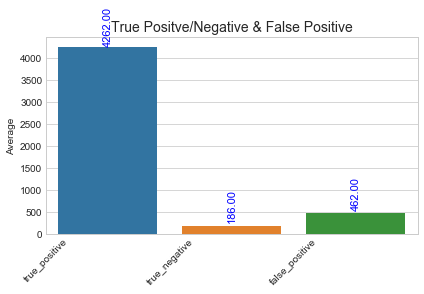

In [36]:
plot_mean_bar(res_positive_negative_df, "True Positve/Negative & False Positive", "mean_positive_negative")

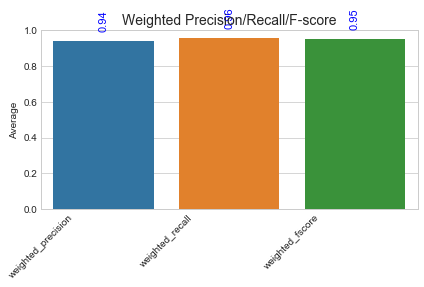

In [37]:
plot_mean_bar(res_weighted_precision_recall_fscore_df, "Weighted Precision/Recall/F-score", "mean_weighted_precision_recall_fscore", [0,1])

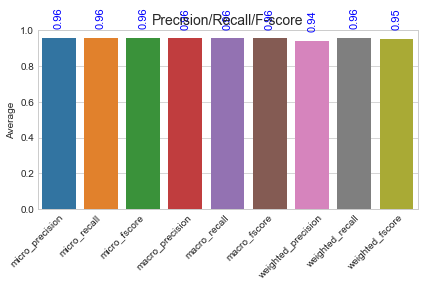

In [38]:
plot_mean_bar(res_precision_recall_fscore_df, "Precision/Recall/F-score", "mean_precision_recall_fscore", [0,1])

In [39]:
df1 = res_positive_negative_df

def prep_df(df, name):
    df = df.stack().reset_index()
    df.columns = ['c1', 'c2', 'values']
    df['DF'] = name
    return df

df1 = prep_df(df1, 'Count')

df = pd.concat([df1])  
# print (df)

alt.enable_mime_rendering()

alt.Chart(df).mark_bar().encode(

    # tell Altair which field to group columns on
    x=alt.X('c2:N',
        axis=alt.Axis(
            title='')),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(values):Q',
        axis=alt.Axis(
            grid=False,
            title='')),

    # tell Altair which field to use to use as the set of columns to be represented in each group
    column=alt.Column('c1:N',
                 axis=alt.Axis(
            title='')),

    # tell Altair which field to use for color segmentation 
    color=alt.Color('DF:N',
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['#96ceb4', '#ffcc5c','#ff6f69'],
            ),
        ))\
    .configure_facet_cell(
    # remove grid lines around column clusters
        strokeWidth=0.0)

<altair.VegaLite object>

In [40]:
df1 = precision_df
df2 = recall_df
df3 = fscore_df

def prep_df(df, name):
    df = df.stack().reset_index()
    df.columns = ['c1', 'c2', 'values']
    df['DF'] = name
    return df

df1 = prep_df(df1, 'Precision')
df2 = prep_df(df2, 'Recall')
df3 = prep_df(df3, 'F-Score')

df = pd.concat([df1, df2, df3])  
# print (df)

alt.enable_mime_rendering()

alt.Chart(df).mark_bar().encode(

    # tell Altair which field to group columns on
    x=alt.X('c2:N',
        axis=alt.Axis(
            title='')),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(values):Q',
        axis=alt.Axis(
            grid=False,
            title='')),

    # tell Altair which field to use to use as the set of columns to be represented in each group
    column=alt.Column('c1:N',
                 axis=alt.Axis(
            title='')),

    # tell Altair which field to use for color segmentation 
    color=alt.Color('DF:N',
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['#96ceb4', '#ffcc5c','#ff6f69'],
            ),
        ))\
    .configure_facet_cell(
    # remove grid lines around column clusters
        strokeWidth=0.0)
    

<altair.VegaLite object>

## This section selects the best result and generates network graph

#### The network graph consists of 

* Node Type: Author, Paper
* Edge Type: writes, co-authored with, is same paper as, is same person as
  - writes :  Author - writes - Paper
  - co-authored with : Author - co-authored with - Author
  - is same paper as : Paper - is same paper as - Paper
  - is same person as : Author - is same person as - Author
  
* For 'is same person as', we first identify a pair of correctly matched (true positive) paper from both ACM and DBLP sets, then we map each author in the DBLP paper to at least 1 author in the ACM paper using LSH.






In [41]:
def get_best_run():
    """
    get datasets with max true positive
    """ 
    res = resdf[['set_id','true_positive']].sort_values('true_positive', ascending=False) 
    best_set_id = res.iloc[0]['set_id']
    return fout_dir + 'data_matching_output_' + str(best_set_id) + '.csv'    

In [42]:
def checkifstr(obj):
    if isinstance(obj, float):
        return False
    else:
        return bool(obj) and all(isinstance(elem, str) for elem in obj)

In [43]:
def has_token_seq(token_seq):
    m_hash = MinHash(NUM_PERM)
    for word in token_seq:
        m_hash.update(word.encode('utf8'))
    return m_hash

In [44]:
def add_to_index(lsh, mention_id, mention_tokens):
    if not mention_id in lsh:
        m_hash = has_token_seq(mention_tokens)
        lsh.insert(mention_id, m_hash)

In [45]:
def send_query(lsh, tokenized_query):
    hash_query = has_token_seq(tokenized_query)
    return lsh.query(hash_query)

In [46]:
# Hash a list of author
def hash_data(data_ls, data_dict):
    lsh = MinHashLSH(threshold=SIM_THRES, num_perm=NUM_PERM)
    for a in data_ls:    
        cleaned_token = a.split()  
        mid = data_dict.get(a)
        add_to_index(lsh, (mid,a), cleaned_token) 
    return lsh

In [47]:
def create_node_dict(node_id, node_typ, node_label, node_extref_id):
    node_dict = {}
    node_dict['Id'] = node_id
    node_dict['Type'] = node_typ
    node_dict['Label'] = node_label
    node_dict['Extref_Id'] = node_extref_id
    return node_dict

In [48]:
def create_edge_dict(node1, rel, node2):
    rel_dict = {}
    rel_dict['Source'] = node1
    rel_dict['Rel'] = rel
    rel_dict['Target'] = node2
    return rel_dict

In [49]:
def link_similar_authors(dict_node_acm_author, acm_authors_proc, dict_node_dblp2_author, dblp2_authors_proc):
    # create index with one author set, which is ACM author set for this one
    hash_bucket = hash_data(acm_authors_proc, dict_node_acm_author)   
    
    # get a list of candidate for each author
    authors_candidates = {}
    for a in dblp2_authors_proc:
        cleaned_token = a.split()
        candidate_ls = send_query(hash_bucket, cleaned_token)
        dblp2_id = dict_node_dblp2_author.get(a)
        authors_candidates[(dblp2_id, a)] = candidate_ls
    
    # map all candidates to each author (instead of selecting one)
    sim_authors = []
    for k, v in authors_candidates.items():
        node1 = k[0]
        rel = 'is same person as'
        for sv in v:
            node2 = sv[0]
            sim_authors.append(create_edge_dict(node1, rel, node2))
    return sim_authors
        

In [50]:
def link_similar_papers(dict_node_acm_title, acm_title_proc, dict_node_dblp2_title, dblp2_title_proc):
    node1 = dict_node_acm_title.get(acm_title_proc)
    rel = 'is same paper as'
    node2 = dict_node_dblp2_title.get(dblp2_title_proc)
    return ([create_edge_dict(node1, rel, node2)])

In [51]:
def populate_coauthor_edge(authors_dict, authors_list):
    co_authorship = []
    for i in range(len(authors_list)):
        for j in range(i+1, len(authors_list)):
            node1 = authors_dict.get(authors_list[i])
            node2 = authors_dict.get(authors_list[j])
            rel = 'co-authored with'
#             print (node1, " co-authored with ", node2)
            if node1 is not None and node2 is not None:
                co_authorship.append(create_edge_dict(node1, rel, node2))
            elif node1 is None:
                print ('populate_coauthor_edge:', node1, ' not found')
            elif node2 is None:
                print ('populate_coauthor_edge:', node2, ' not found')
    return co_authorship

In [52]:
def populate_write_edge(authors_dict, authors_list, paper_dict, title_proc):
    authoring = []
    rel = 'writes'
    node2 = paper_dict.get(title_proc)
    for i in range(len(authors_list)):
        node1 = authors_dict.get(authors_list[i])
        if node1:
            authoring.append(create_edge_dict(node1, rel, node2))
        else:
            print ('populate_write_edge:', authors_list[i], ' not found')
    return authoring

In [59]:

def populate_graph(res_map, true_map):
    
    #TODO: check EMPTY  res_map, true_map, df_acm, df_dblp2
    
    
    # Get a list of author nodes (name, paper-id, node-typ)
    df_acm_idx               = df_acm.set_index(['id'])
    df_acm_idstr             = df_acm['id'].astype(str).tolist()
    df_dblp2_idx             = df_dblp2.set_index(['id'])

    global_id                = 0
    NODE_TYP_AUTHOR_ACM      = 0
    NODE_TYP_AUTHOR_DBLP2    = 1
    NODE_TYP_PAPER_ACM       = 2
    NODE_TYP_PAPER_DBLP2     = 3

    dict_node                = {}     # map { id: original author or paper name}
    dict_node_acm_author     = {}     # map { author_proc_name: id}
    dict_node_dblp2_author   = {}
    dict_node_acm_paper      = {}     # map { paper_proc_name: id}
    dict_node_dblp2_paper    = {}     

    node_arr                 = []     # to create nodes.csv (including author and paper)
    author_paper_arr         = []     # to create 'author [writes] paper' rel. 
    coauthor_link_arr        = []     # to create 'author [co-authored with] author' rel.
    is_same_author_link_arr  = []     # to create 'author [is same person as] author' rel. 
    is_same_paper_link_arr   = []     # to create 'paper [is same paper as] paper' rel. 

    for k, pred_v in res_map.items():
        if true_map.get(k) is not None:
            true_v = true_map.get(k)        
            if true_v == pred_v:
                if k in df_acm_idstr:   # Filter only one-way
                    acm_authors   = df_acm_idx.loc[int(k)].authors
                    dblp2_authors = df_dblp2_idx.loc[pred_v].authors
                    acm_title     = df_acm_idx.loc[int(k)].title
                    dblp2_title   = df_dblp2_idx.loc[pred_v].title

                    # Create paper node
                    proc_acm_title = preProcess(acm_title)
                    dict_node_acm_paper[proc_acm_title] = global_id
                    dict_node[global_id] = acm_title
                    node_prop = create_node_dict(global_id, NODE_TYP_PAPER_ACM, acm_title, k)
                    node_arr.append(node_prop)
                    global_id += 1

                    proc_dblp2_title = preProcess(dblp2_title)
                    dict_node_dblp2_paper[proc_dblp2_title] = global_id
                    dict_node[global_id] = dblp2_title
                    node_prop = create_node_dict(global_id, NODE_TYP_PAPER_DBLP2, dblp2_title, pred_v)
                    node_arr.append(node_prop)
                    global_id += 1

                    # Populate co-author list
                    acm_authors_proc = []
                    dblp2_authors_proc = []

                    # Create author node
                    if checkifstr(acm_authors):
                        for oa in acm_authors.split(','):
                            a = preProcess(oa)
                            acm_authors_proc.append(a)
                            if a not in dict_node_acm_author:
                                dict_node_acm_author[a] = global_id
                                dict_node[global_id] = oa
                                node_prop = create_node_dict(global_id, NODE_TYP_AUTHOR_ACM, oa, k)
                                node_arr.append(node_prop)
                                global_id += 1

                    if checkifstr(dblp2_authors):
                        for oa in dblp2_authors.split(','):
                            a = preProcess(oa)
                            dblp2_authors_proc.append(a)
                            if a not in dict_node_dblp2_author:
                                dict_node_dblp2_author[a] = global_id
                                dict_node[global_id] = oa
                                node_prop = create_node_dict(global_id, NODE_TYP_AUTHOR_DBLP2, oa, pred_v)
                                node_arr.append(node_prop)
                                global_id += 1

                    # Populate co-author list
                    edges_list = populate_coauthor_edge(dict_node_acm_author, acm_authors_proc)
                    coauthor_link_arr.extend(edges_list)
                    edges_list = populate_coauthor_edge(dict_node_dblp2_author, dblp2_authors_proc)
                    coauthor_link_arr.extend(edges_list)

                    # Link similar author in both lists
                    edges_list = link_similar_authors(dict_node_acm_author, acm_authors_proc, dict_node_dblp2_author, dblp2_authors_proc)
                    is_same_author_link_arr.extend(edges_list)

                    # Link similar paper
                    edge_list = link_similar_papers(dict_node_acm_paper, proc_acm_title, dict_node_dblp2_paper, proc_dblp2_title)
                    is_same_paper_link_arr.extend(edge_list)

                    # Populate authoring edge
                    edges_list = populate_write_edge(dict_node_acm_author, acm_authors_proc, dict_node_acm_paper, proc_acm_title)
                    author_paper_arr.extend(edges_list)
                    edges_list = populate_write_edge(dict_node_dblp2_author, dblp2_authors_proc, dict_node_dblp2_paper, proc_dblp2_title)
                    author_paper_arr.extend(edges_list)
                    
    return [node_arr, coauthor_link_arr, is_same_author_link_arr, is_same_paper_link_arr, author_paper_arr]
        

In [54]:
def gen_graph(res_map, true_map):
    [node_arr, coauthor_link_arr, is_same_author_link_arr, is_same_paper_link_arr, author_paper_arr] = populate_graph(res_map, true_map)
    
    snag = SNA_Graph()
    nodels = []
    edgels = []

    for n in node_arr:
        attr = {}
        attr['Extref_Id'] = n.get('Extref_Id')
        nodels.append(snag.create_node(str(n.get('Id')) + '_' + n.get('Label'), 
                                       n.get('Label'),
                                       n.get('Type')))
    for e in coauthor_link_arr:
        src = e.get('Source')
        dst = e.get('Target')
        edgels.append(snag.create_edge(str(src) + '_' + dict_node.get(src), 
                                       str(dst) + '_' + dict_node.get(dst),
                                       e.get('Rel')))
    for e in is_same_author_link_arr:
        src = e.get('Source')
        dst = e.get('Target')
        edgels.append(snag.create_edge(str(src) + '_' + dict_node.get(src), 
                                       str(dst) + '_' + dict_node.get(dst),
                                       e.get('Rel')))

    for e in is_same_paper_link_arr:
        src = e.get('Source')
        dst = e.get('Target')
        edgels.append(snag.create_edge(str(src) + '_' + dict_node.get(src), 
                                       str(dst) + '_' + dict_node.get(dst),
                                       e.get('Rel')))
    for e in author_paper_arr:
        src = e.get('Source')
        dst = e.get('Target')
        edgels.append(snag.create_edge(str(src) + '_' + dict_node.get(src), 
                                       str(dst) + '_' + dict_node.get(dst),
                                       e.get('Rel')))

    g_author = snag.create_graph('Author-Paper Network Graph', nodels, edgels)
    nx.write_gml(g_author, author_paper_gml)

In [55]:
if GEN_GRAPH: 
    fres_dedupe = get_best_run()
    true_map = read_ground_truth()
    res_map  = read_dedupe_result(fres_dedupe)
    gen_graph(res_map, true_map)
else:
    snag = nx.read_gml(author_paper_gml)

FileNotFoundError: [Errno 2] No such file or directory: 'output/DBLP_ACM/author_paper.gml'

## This section provides an overview of graph analytics.

#### We first identify the number of connected component, we then dive into a selected connected component and analyse the network properties of this component.

In [ ]:
# Check number of connected component
sna_cc = SNA_ConnectedComponent(snag)
print ("Number of connected component:", sna_cc.get_number_of_connected_component())

# Extract subgraph of connected component N
connected_component_N = 3
selected_cc = sna_cc.get_descending_sorted_connected_component_by_ranking(connected_component_N)
print ("Number of node in selected connected component:", len(selected_cc))

# Analyse subgraph (selected component) and write subgraph to GML
sna_ana = SNA_Analytics(selected_cc, connected_component_gml)
sna_ana.analyse_network()
sna_ana.write_gml()

In [ ]:
# TODO: Check out http://holoviews.org/user_guide/Network_Graphs.html
hv.extension('bokeh')
%opts Graph [width=600 height=600]
hv.Graph.from_networkx(selected_cc, nx.layout.spring_layout)

#### Miscellaneous functions

In [76]:
def write_csv(fname, headernames, data_arr, write_header):
    with io.open(fname, 'a+b') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headernames)
        if write_header:
            writer.writeheader()
        for r in data_arr:
            writer.writerow(r)
            
def gen_csv():
    fnodes            = fout_dir + 'nodes.csv'
    fedges            = fout_dir + 'edges.csv'
    [node_arr, coauthor_link_arr, is_same_author_link_arr, is_same_paper_link_arr, author_paper_arr] = populate_graph(res_map, true_map)     
    write_csv(fnodes, ['Id', 'Extref_Id', 'Type', 'Label'], node_arr, True)
    write_csv(fedges, ['Source', 'Rel', 'Target'], author_paper_arr, True)
    write_csv(fedges, ['Source', 'Rel', 'Target'], coauthor_link_arr, False)